In [1]:
from random import uniform
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [2]:
class ConvLayer:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = [[uniform(-1, 1) for _ in range(filter_size)] for _ in range(num_filters)]

    def relu(self, x):
        return max(0, x)

    def iterate_regions(self, image):
    h, w = len(image), len(image[0])

    for i in range(h - self.filter_size + 1):
        for j in range(w - self.filter_size + 1):
            im_region = [[image[i+x][j+y] for y in range(self.filter_size)] for x in range(self.filter_size)]
            yield im_region, i, j

    def forward(self, input):
        self.last_input = input

        h, w = len(input), len(input[0])
        output = [[[0]*self.num_filters for _ in range(w - self.filter_size + 1)] for _ in range(h - self.filter_size + 1)]

        for im_region, i, j in self.iterate_regions(input):
            output[i][j] = [self.relu(sum(im_region[x][y] * self.filters[f][x][y] for x in range(self.filter_size) for y in range(self.filter_size))) for f in range(self.num_filters)]

        return output


In [3]:
class MaxPool2:
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def iterate_regions(self, image):
        h, w, _ = len(image), len(image[0]), len(image[0][0])
        new_h = h // self.pool_size
        new_w = w // self.pool_size

        for i in range(new_h):
            for j in range(new_w):
                im_region = [[image[i*self.pool_size+x][j*self.pool_size+y] for y in range(self.pool_size)] for x in range(self.pool_size)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input

        h, w, num_filters = len(input), len(input[0]), len(input[0][0])
        output = [[[0]*num_filters for _ in range(w // self.pool_size)] for _ in range(h // self.pool_size)]

        for im_region, i, j in self.iterate_regions(input):
            output[i][j] = [max(max(row)) for row in zip(*im_region)]

        return output

In [4]:
class Flatten:
    def forward(self, input):
        self.last_input_shape = len(input), len(input[0]), len(input[0][0])
        input_flattened = [item for sublist1 in input for sublist2 in sublist1 for item in sublist2]
        self.last_input = input_flattened
        return input_flattened

In [5]:
class Neuron:
    def __init__(self, num_inputs):
        self.weights = [uniform(-1, 1) for _ in range(num_inputs)]
        self.bias = uniform(-1, 1)
        self.output = 0
        self.input_sum = 0

    # Sigmoid activation
    def sigmoid(self, x):
        return 1 / (1 + (1 / self.exp(x)))

    def activate(self):
        self.output = self.sigmoid(self.input_sum + self.bias)

    # def activate(self):
    #     self.output = 1 / (1 + (1 / self.exp(self.input_sum + self.bias)))

    # Approximate e^x for activation function
    def exp(self, x):
        n = 1
        sum = 1
        for i in range(1, 100):
            n *= x / i
            sum += n
        return sum

In [6]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, input):
        self.mask = [uniform(0, 1) > self.rate for _ in range(len(input))]
        return [i * m for i, m in zip(input, self.mask)]

In [7]:
class Layer:
    def __init__(self, num_neurons, num_inputs):
        self.neurons = [Neuron(num_inputs) for _ in range(num_neurons)]

In [8]:
class Link:
    def __init__(self, source_neuron, target_neuron, weight):
        self.source = source_neuron
        self.target = target_neuron
        self.weight = weight

In [9]:
class LayerLink:
    def __init__(self, source_layer, target_layer):
        self.links = []
        for source_neuron in source_layer.neurons:
            for target_neuron in target_layer.neurons:
                link = Link(source_neuron, target_neuron, 0)
                self.links.append(link)
                target_neuron.weights.append(link.weight)

In [10]:
class Network:
    def __init__(self):
        self.layers = []
        self.layer_links = []

    def add_conv_layer(self, num_filters, filter_size):
        layer = ConvLayer(num_filters, filter_size)
        self.layers.append(layer)


    def initialize_weights_randomly(self):
        for layer_link in self.layer_links:
            for link in layer_link.links:
                link.weight = self.random()

    def initialize_network_from_file(self, filename):
        with open(filename, 'r') as f:
            num_layers = int(f.readline().strip())  # Read the number of layers
            print(f"Number of layers: {num_layers}")

            layer_sizes = [int(f.readline().strip()) for _ in range(num_layers)]  # Read the layer sizes
            print("Number of neurons in each layer:")
            
            for i, size in enumerate(layer_sizes):
                print(f"Layer {i+1}: {size} neuron(s)")
            
            input_size = layer_sizes[0]
            for size in layer_sizes[1:]:
                self.layers.append(Layer(size, input_size))
                input_size = size

            self.layer_links = []
            for i in range(len(self.layers) - 1):
                layer_link = LayerLink(self.layers[i], self.layers[i + 1])
                self.layer_links.append(layer_link)

    def feedforward(self, inputs):
            for i, layer in enumerate(self.layers):
                next_inputs = []
                for neuron in layer.neurons:
                    neuron.input_sum = sum(w * i for w, i in zip(neuron.weights, inputs))
                    neuron.activate()
                    next_inputs.append(neuron.output)
                inputs = next_inputs
            return inputs

    def random(self):
        # seed(8)
        return random()

    def print_network_structure(self):
        # for i, layer in enumerate(self.layers):
        #     print(f"\nLayer {i+1}:")
        #     for j, neuron in enumerate(layer.neurons):
        #         print(f"\tNeuron {j+1}:\n\t\tBias: {neuron.bias}\n\t\tWeights: {neuron.weights}\n\t\tOutput: {neuron.output}")

        print("\nConnections:")
        for i, layer_link in enumerate(self.layer_links):
            print("\n############################################################################################")
            print("############################################################################################")
            print(f"From Layer {i+1} to Layer {i+2}:")
            for link in layer_link.links:
                source_index = self.layers[i].neurons.index(link.source)
                target_index = self.layers[i+1].neurons.index(link.target)
                print(f"From Neuron {source_index+1} \n\t(\n\t- weight = {link.source.weights}, \n\t- bias = {link.source.bias}, \n\t- output = {link.source.output}\n\t) \n to Neuron {target_index+1}: \n\t- Weight = {link.weight}, \n\t- Bias = {link.target.bias}, \n\t- Output = {link.target.output}\n")

    def train():
        pass

In [11]:
def custom_cnn_model():
    # Define the CNN model
    network = Network()

    network.add_conv_layer(32, 3)
    network.layers.append(MaxPool2(2))
    network.add_conv_layer(64, 3)
    network.layers.append(MaxPool2(2))
    network.add_conv_layer(128, 3)
    network.layers.append(MaxPool2(2))
    network.layers.append(Flatten())
    network.layers.append(Layer(128, 128*128*128))  # Assuming the input size is 128*128*128
    network.layers.append(Dropout(0.1))
    network.layers.append(Layer(3, 128))
    
    return network


In [12]:
# !gdown "1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw"
# !unzip /content/shoe_sandal_boot.zip

Downloading...
From (original): https://drive.google.com/uc?id=1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw
From (redirected): https://drive.google.com/uc?id=1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw&confirm=t&uuid=16c08600-bdb7-4b15-a08d-549bcfc5facd
To: /storage/student14/phucpg/WORKSPACE/shoe_sandal_boot.zip
100%|██████████████████████████████████████| 49.3M/49.3M [00:04<00:00, 10.6MB/s]
unzip:  cannot find or open /content/shoe_sandal_boot.zip, /content/shoe_sandal_boot.zip.zip or /content/shoe_sandal_boot.zip.ZIP.


(102, 136, 3)


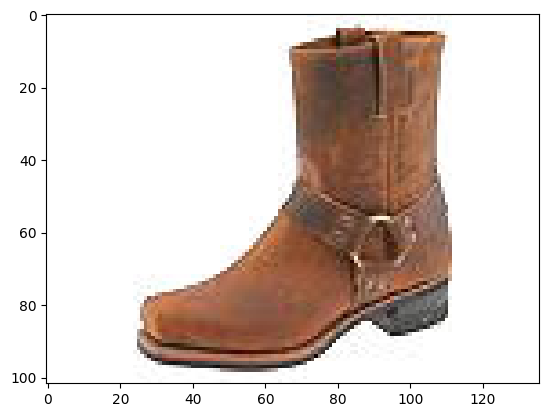

In [16]:
img = cv2.imread(f'Shoe vs Sandal vs Boot Dataset/Boot/boot (1).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
del img

In [17]:
# Path to your image folder
data_dir = "Shoe vs Sandal vs Boot Dataset/"
data_shoe = data_dir + "Shoe/"
data_sandal = data_dir + "Sandal/"
data_boot = data_dir + "Boot/"

# Type of images
shoe = "Shoe"
sandal = "Sandal"
boot = "boot"

# Get all image file paths
shoe_images = [os.path.join(data_shoe, filename) for filename in os.listdir(data_shoe)]
sandal_images = [os.path.join(data_sandal, filename) for filename in os.listdir(data_sandal)]
boot_images = [os.path.join(data_boot, filename) for filename in os.listdir(data_boot)]

In [18]:
print(len(shoe_images))
print(len(sandal_images))
print(len(boot_images))

5000
5000
5000


In [19]:
def load_images(all_images, data_path, data_type):
    images = []
    for index in range(1, len(all_images) + 1):
        img = cv2.imread(f"{data_path}{data_type} ({index}).jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (204, 153))
        images.append(img)
    return images

shoe_data = load_images(shoe_images, data_shoe, shoe)
sandal_data = load_images(sandal_images, data_sandal, sandal)
boot_data = load_images(boot_images, data_boot, boot)
# images = train_images
print(len(shoe_data))
print(len(sandal_data))
print(len(boot_data))

5000
5000
5000


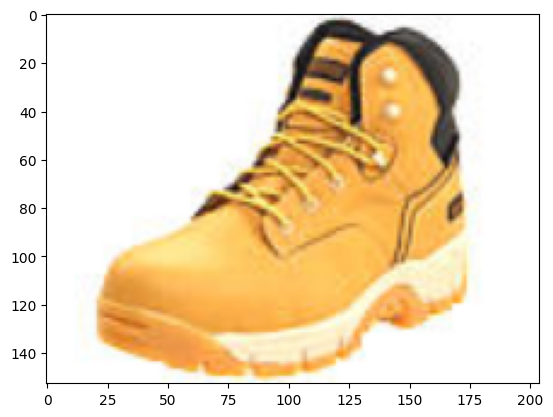

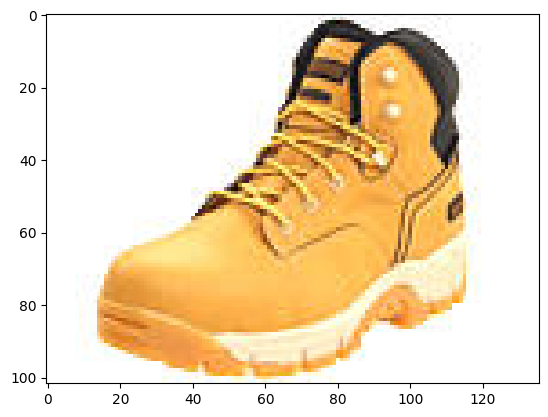

In [20]:
plt.imshow(boot_data[500])
plt.show()

img = cv2.imread('Shoe vs Sandal vs Boot Dataset/Boot/boot (501).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
del img

In [21]:
print(boot_data[500].shape)

(153, 204, 3)


In [23]:
customCNN = custom_cnn_model()